In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.cheminformania.com/building-a-simple-smiles-based-qsar-model-with-lstm-cells-in-pytorch/

In [ ]:
!pip install rdkit &> /dev/null

In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
df = pd.read_excel('All.xlsx').dropna(how='all', axis='columns')
df['S_leng'] = df['SMILES'].str.len()

In [ ]:
df = df.rename(columns = {'IC50, mmg/ml': 'IC50',
                          'CC50-MDCK, mmg/ml': 'CC50',
                          'Molecular weight': 'MW',
                          'Hydrogen bond acceptors': 'HBA',
                          'Hydrogen bond donors': 'HBD',
                          'Polar SA': 'PSA'})

In [ ]:
df.head()

,Title,IC50,CC50,SI,MW,HBA,HBD,PSA,SMILES,Pictures,S_leng
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0,35
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0,35
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0,41
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0,39
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0,44


In [ ]:
len(df)

1468

In [ ]:
df.describe()

,IC50,CC50,SI,MW,HBA,HBD,PSA,Pictures,S_leng
count,1468.000000,1468.000000,1.444000e+03,1468.000000,1468.000000,1468.000000,1468.000000,727.000000,1468.000000
mean,50.277063,186.491530,2.217641e+04,384.739636,3.831744,1.333787,81.273215,364.909216,62.997956
std,92.184768,1009.454293,4.726006e+05,153.164268,2.860473,1.803663,54.078778,210.154325,32.373175
min,0.000010,0.031928,0.000000e+00,110.157000,0.000000,0.000000,0.000000,1.000000,13.000000
25%,2.500000,30.375000,1.885549e+00,283.049250,2.000000,0.000000,39.440000,183.500000,46.000000
50%,10.100000,90.400000,5.600000e+00,349.371000,3.000000,1.000000,71.840000,365.000000,55.000000
75%,49.450000,300.000000,2.832642e+01,446.508000,5.000000,2.000000,106.160000,546.500000,68.000000
max,1000.000000,37646.000000,1.596170e+07,1159.380000,19.000000,11.000000,319.510000,728.000000,279.000000


In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

<ipython-input-58-935c2e534e54>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,IC50,CC50,SI,MW,HBA,HBD,PSA,Pictures,S_leng
IC50,1.000000,0.054449,-0.025403,-0.124947,-0.070279,-0.137051,-0.076304,0.135774,-0.110493
CC50,0.054449,1.000000,0.019088,-0.000079,-0.009657,0.013175,0.016038,-0.033486,0.011527
SI,-0.025403,0.019088,1.000000,-0.007741,0.011466,0.016641,0.051136,-0.107206,-0.006658
MW,-0.124947,-0.000079,-0.007741,1.000000,0.713369,0.534786,0.738870,0.148361,0.881565
HBA,-0.070279,-0.009657,0.011466,0.713369,1.000000,0.646138,0.812043,0.060206,0.682413
HBD,-0.137051,0.013175,0.016641,0.534786,0.646138,1.000000,0.752662,-0.028040,0.622681
PSA,-0.076304,0.016038,0.051136,0.738870,0.812043,0.752662,1.000000,0.244553,0.673769
Pictures,0.135774,-0.033486,-0.107206,0.148361,0.060206,-0.028040,0.244553,1.000000,0.012710
S_leng,-0.110493,0.011527,-0.006658,0.881565,0.682413,0.622681,0.673769,0.012710,1.000000


In [ ]:
df = df[df.S_leng < 150]

In [ ]:
# df = df[df['IC50'] < 50]
df['IC50'] = df['IC50'].apply(lambda x: x if x < 300 else 300)
df['IC50'] = df['IC50'].apply(lambda x: np.log(x + 1))

In [ ]:
df = df[df['CC50'] < 600]

In [ ]:
numerical_features = ['CC50', 'MW', 'HBA', 'HBD', 'PSA']
df[numerical_features] = MinMaxScaler().fit_transform(df[numerical_features])

In [ ]:
df_w = df[['IC50', 'CC50', 'MW', 'HBA', 'HBD', 'PSA', 'SMILES']]

In [ ]:
df_w.describe()

,IC50,CC50,MW,HBA,HBD,PSA
count,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000
mean,2.618738,0.275371,0.351239,0.211922,0.107851,0.260361
std,1.710274,0.264139,0.170063,0.143210,0.139283,0.164128
min,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.252763,0.056907,0.230911,0.117647,0.000000,0.132804
50%,2.442347,0.169004,0.317101,0.176471,0.090909,0.234528
75%,3.970292,0.565372,0.438693,0.294118,0.181818,0.346867
max,5.707110,1.000000,1.000000,1.000000,1.000000,1.000000


## Анализ данныз

<Axes: xlabel='S_leng', ylabel='Count'>

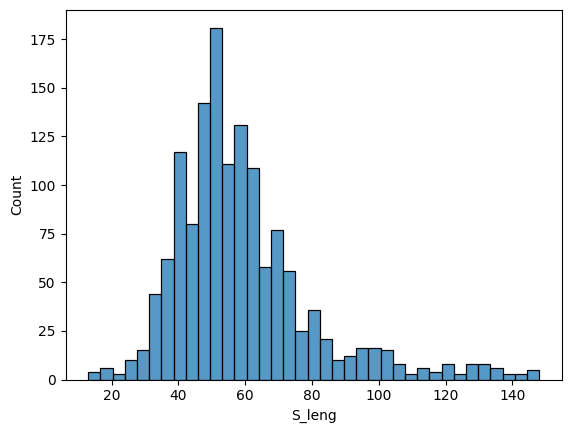

In [ ]:
sns.histplot(df['S_leng'])

<Axes: xlabel='IC50', ylabel='Count'>

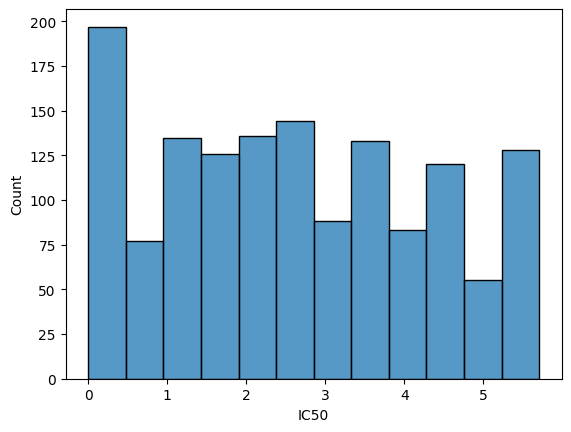

In [ ]:
sns.histplot(df['IC50'])

<Axes: xlabel='CC50', ylabel='Count'>

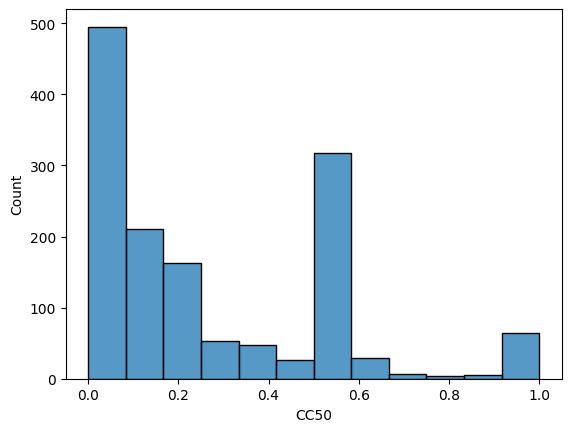

In [ ]:
sns.histplot(df['CC50'])

<Axes: xlabel='MW', ylabel='Count'>

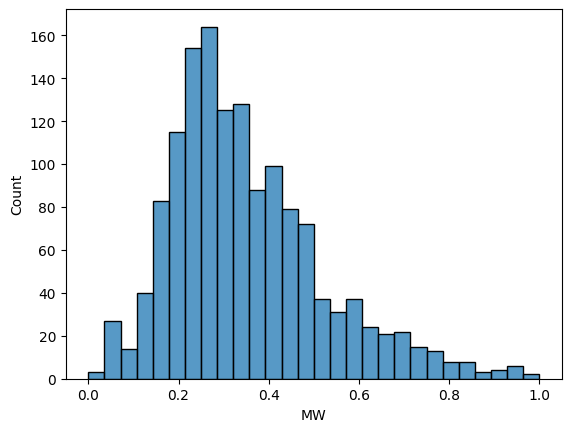

In [ ]:
sns.histplot(df['MW'])

<Axes: xlabel='HBA', ylabel='Count'>

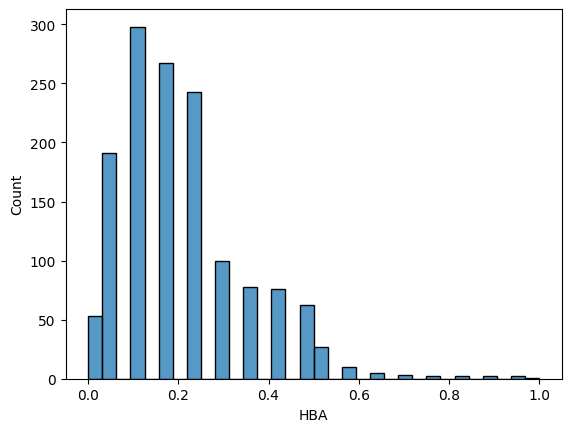

In [ ]:
sns.histplot(df['HBA'])

<Axes: xlabel='HBD', ylabel='Count'>

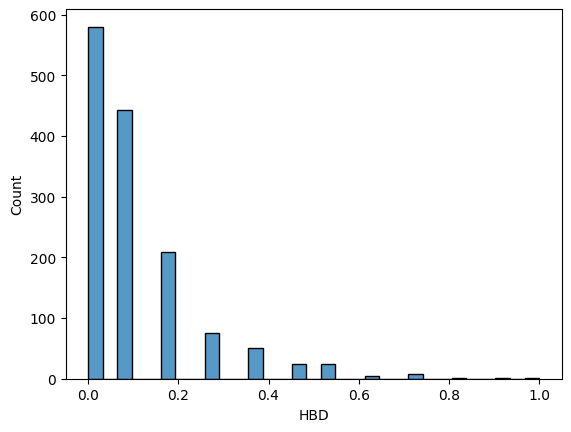

In [ ]:
sns.histplot(df['HBD'])

<Axes: xlabel='PSA', ylabel='Count'>

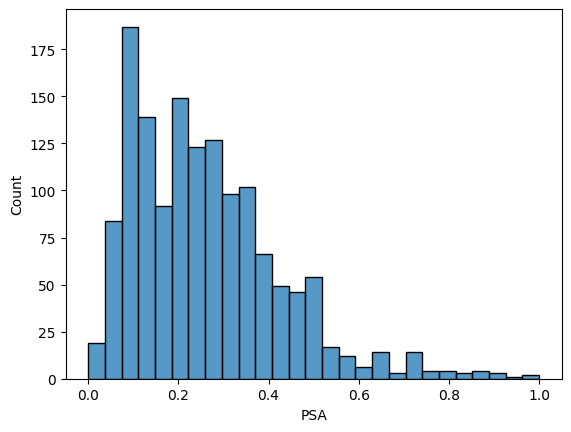

In [ ]:
sns.histplot(df['PSA'])

In [ ]:
corr = df_w.corr()
corr.style.background_gradient(cmap='coolwarm')

<ipython-input-74-d17939179aa4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_w.corr()


,IC50,CC50,MW,HBA,HBD,PSA
IC50,1.000000,0.516129,-0.060865,-0.089506,-0.167370,-0.138918
CC50,0.516129,1.000000,-0.123154,-0.091270,-0.201077,-0.181925
MW,-0.060865,-0.123154,1.000000,0.608116,0.348464,0.673457
HBA,-0.089506,-0.091270,0.608116,1.000000,0.516997,0.768265
HBD,-0.167370,-0.201077,0.348464,0.516997,1.000000,0.686902
PSA,-0.138918,-0.181925,0.673457,0.768265,0.686902,1.000000


## Векторайзер

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES", "Molecule"]]

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
0,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba9d0>
1,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba730>
2,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba6c0>
3,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba8f0>
4,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba810>
...,...,...
1459,COC(=O)CN1CCOCC1,<rdkit.Chem.rdchem.Mol object at 0x79ad850ed850>
1460,CC(C)CCCc1c(OC)c(C)c(=O)oc1,<rdkit.Chem.rdchem.Mol object at 0x79ad850ed8c0>
1461,C[C@]12C(C)(C)[C@@H](CC2)C[C@H]1O,<rdkit.Chem.rdchem.Mol object at 0x79ad850ed930>
1462,CCCCCCCc1c(O)c(C)c(=O)oc1,<rdkit.Chem.rdchem.Mol object at 0x79ad850ed9a0>


In [ ]:
!python -m pip install git+https://github.com/EBjerrum/molvecgen &> /dev/null

In [ ]:
from molvecgen.vectorizers import SmilesVectorizer

In [ ]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df_w.Molecule.values, )

In [ ]:
print(smivec.charset)
smivec.dims

3l[ioI/O\.nN7arc-B=HP)1]+(6F4CS2#s@e5^$?


(146, 40)

In [ ]:
df_w['IC50']

0       1.308333
1       0.530628
2       2.388763
3       2.230014
4       3.698830
          ...   
1459    5.707110
1460    2.653242
1461    3.218876
1462    2.873565
1463    2.116256
Name: IC50, Length: 1422, dtype: float64

In [ ]:
y = df_w['IC50'].values.reshape((-1,1))
X = df_w.drop(['IC50', 'SMILES'], axis=1)
X['Molecule'] = X.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=seed)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)
#Normalizing output using standard scaling
# scaler = MinMaxScaler()
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [ ]:
X.head()

,CC50,MW,HBA,HBD,PSA,Molecule
0,0.942326,0.114821,0.117647,0.090909,0.109738,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba9d0>
1,0.842433,0.114821,0.117647,0.090909,0.109738,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba730>
2,0.271347,0.189154,0.058824,0.000000,0.052529,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba6c0>
3,0.942326,0.151324,0.058824,0.000000,0.052529,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba8f0>
4,0.269462,0.174226,0.117647,0.000000,0.099468,<rdkit.Chem.rdchem.Mol object at 0x79ad856ba810>


In [ ]:
y_train.shape

(852, 1)

In [ ]:
y_test.shape

(356, 1)

In [ ]:
class SMILESMolDataset(Dataset):
    def __init__(self, x, y, vectorizer):
        x = x.reset_index()
        self.molecules = x['Molecule']
        self.features = x.drop(['Molecule', 'index'], axis=1)
        self.y = y
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.molecules)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]

        #The vectorizer was written to work with batches,
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        features = self.features.loc[idx].values
        label = self.y[idx]
        return sample, features, label

In [ ]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
test_dataset = SMILESMolDataset(X_test, y_test, smivec)
validation_dataset = SMILESMolDataset(X_validation, y_validation, smivec)
train_dataset[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([0.2707816 , 0.62636396, 0.23529412, 0.18181818, 0.65586908]),
 array([0.73048191]))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Net(nn.Module):
    def __init__(self, dimensions, hidden_size, dropout_rate, out_size, num_numerical_features):
        super(Net, self).__init__()

        length = dimensions[0]
        number_tokens = dimensions[1]

        self.lstm = nn.GRU(input_size=number_tokens, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=False, dropout = 0.2)
        self.dense = nn.Linear(num_numerical_features, hidden_size)

        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.activation1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.activation2 = nn.ReLU()

        self.fc_out = nn.Linear(hidden_size//2, out_size) # Output layer

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, molecules_data, numerical_data):# Forward pass: stacking each layer together
        #out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out, h_n = self.lstm(molecules_data) #GRU network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        molecules_out = self.dropout(h_n) #Dropout
        numerical_out = self.dense(numerical_data)

        combined = torch.cat([molecules_out[0], numerical_out], dim=1)

        out = self.fc1(combined) # Pass into the fc1 layer
        out = self.activation1(out) # Use ReLU on hidden activation

        out = self.fc2(out) # Pass into the fc2 layer
        out = self.activation2(out) # Use ReLU on hidden activation

        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

In [ ]:
epochs = 100
dims = smivec.dims
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.5 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.003  # The initial learning rate for the optimizer
num_numerical_features = len(train_dataset[0][1])

In [ ]:
model = Net(dims, hidden_size, dropout_rate, output_size, num_numerical_features)
model.cuda()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Net(
  (lstm): GRU(40, 32, batch_first=True, dropout=0.2)
  (dense): Linear(in_features=5, out_features=32, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (activation1): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (activation2): ReLU()
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, features, labels in train_loader:
        # Push numpy to CUDA tensors
        smiles = smiles.clone().detach().to(device).float()
        features = features.clone().detach().to(device).float()
        labels = labels.clone().detach().to(device).float()
        labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))
        #print(labels)
        #break
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles, features) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss

        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:
        model.eval()
        validation_loss = 0
        for smiles, features, labels in validation_loader:
            smiles = smiles.clone().detach().to(device).float()
            features = features.clone().detach().to(device).float()
            labels = labels.clone().detach().to(device).float()
            labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))

            output = model(smiles, features) #Forward pass of the mini-batch
            loss = criterion(output, labels) #Computing the loss
            validation_loss += loss.item()

        validation_loss /= len(validation_loader)
        lr_scheduler.step(validation_loss)

        model.train()

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%5 == 0:
            print("Epoch %i, Training loss: %0.5F Validation loss: %0.5F"%(e + 1, train_loss, validation_loss))

Epoch 5, Training loss: 0.75732 Validation loss: 0.79459
Epoch 10, Training loss: 0.76205 Validation loss: 0.70953
Epoch 15, Training loss: 0.71504 Validation loss: 0.69742
Epoch 20, Training loss: 0.67863 Validation loss: 0.68111
Epoch 25, Training loss: 0.66461 Validation loss: 0.65064
Epoch 30, Training loss: 0.64499 Validation loss: 0.60997
Epoch 35, Training loss: 0.66646 Validation loss: 0.61476
Epoch 40, Training loss: 0.63396 Validation loss: 0.55495
Epoch 45, Training loss: 0.58532 Validation loss: 0.64663
Epoch 50, Training loss: 0.62827 Validation loss: 0.56453
Epoch 55, Training loss: 0.55762 Validation loss: 0.57963
Epoch 60, Training loss: 0.56647 Validation loss: 0.54197
Epoch 65, Training loss: 0.56704 Validation loss: 0.56636
Epoch 70, Training loss: 0.51341 Validation loss: 0.54618
Epoch 75, Training loss: 0.49072 Validation loss: 0.55429
Epoch 80, Training loss: 0.51571 Validation loss: 0.50484
Epoch 85, Training loss: 0.50596 Validation loss: 0.55652
Epoch 90, Train

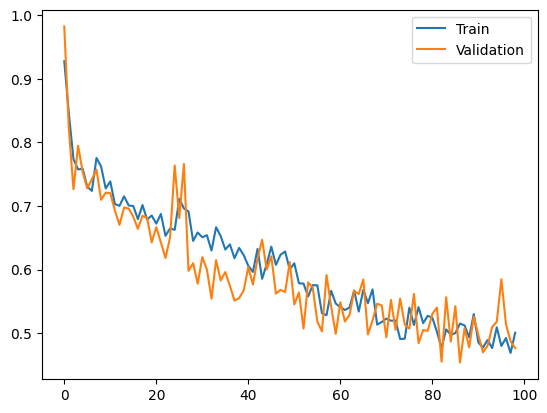

In [ ]:
plt.plot(train_losses[1:], label="Train")
plt.plot(validation_losses[1:], label="Validation")
#plt.yscale('log')
plt.legend()

In [ ]:
model.eval();

In [ ]:
torch.cuda.empty_cache()

In [ ]:
vert = np.array(y_test.tolist()).flatten()
horz = list()
for i in range(len(test_dataset)):
    smiles, features, label = test_dataset[0]
    smiles = torch.tensor([smiles]).clone().detach().to(device).float()
    features = torch.tensor([features]).clone().detach().to(device).float()
    horz.append(model.forward(smiles, features).item())
horz = np.array(horz)

<ipython-input-98-9062bd0a89a3>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  smiles = torch.tensor([smiles]).clone().detach().to(device).float()


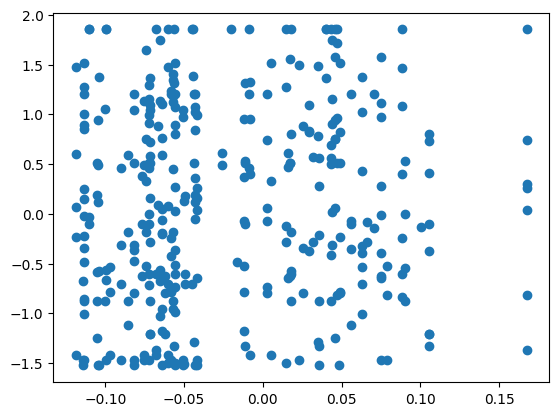

In [ ]:
plt.scatter(horz, vert)